In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib as plt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas_datareader as pdr
# AD−AS model - Medium−run equilibrium
# Parameters 
c, b, k, h, t = 0.6, 1500, 4.0, 1000, 0.2
alpha = 0.4  # capital share in production
aux = (c * (1 - t) - 1) / b - k / h  # auxiliary variable for AD curve
# Exogenous variables
G_bar, W_bar, K_bar, A_bar_initial = 200, 10, 5000, 1
# Autonomous components
C_bar, I_bar, L_bar = 160, 100, 225
# Fetch the M2 money supply data from FRED using pandas data reader
start_date = '1983-01-01'
end_date = '1983-12-31'
M2 = pdr.DataReader('M2SL', 'fred', start_date, end_date)
# Calculate the average value for the year 1983
M_bar = M2['M2SL'].mean()
# AD−AS model as a system of non-linear equations
def ADAS_system(variables, A_bar):
    (Y, P) = variables
    AD_eq = Y - 1 / h * (L_bar - M_bar / P) / aux + 1 / b * (C_bar + I_bar + G_bar) / aux
    AS_eq = Y - A_bar * K_bar ** alpha * (W_bar / P * K_bar ** (-alpha) / ((1 - alpha) * A_bar)) ** ((alpha - 1) / alpha)
    return [AD_eq, AS_eq]
# Function to find A_bar that delivers P = 1 using fixed-point iteration from scipy
def find_A_for_P_1(A_guess):
    def update_A(A):
        # Solve the AD-AS system for given A
        Y_star, P_star = opt.fsolve(lambda vars: ADAS_system(vars, A), (500, 5))
        # Update A using the relation P_star = 1
        return A * P_star
    # Use fixed-point iteration to find A such that P_star = 1
    A_result = opt.fixed_point(update_A, A_guess)
    return A_result
# Find A_bar that delivers P = 1 using fixed-point iteration from scipy
A_bar_for_P_1 = find_A_for_P_1(A_bar_initial)
print("Value of productivity A_bar that delivers an endogenous price level P equal to 1:", A_bar_for_P_1)
# Calculate endogenous variables
Y_star, P_star = opt.fsolve(lambda vars: ADAS_system(vars, A_bar_for_P_1), (500, 5))
R_star = 1 / h * (L_bar - M_bar / P_star + k * Y_star)
C_star = C_bar + c * (1 - t) * Y_star
I_star = I_bar + b * R_star
# Create a DataFrame to hold the results
data = {
    'Variable': ['GDP (Y)', 'Price Level (P)', 'Consumption (C)', 'Investment (I)', 'Interest Rate (r)'],
    'Value': [Y_star, P_star, C_star, I_star, R_star]
}
df = pd.DataFrame(data)
print("\nValues of the variables:")
print(df)

Value of productivity A_bar that delivers an endogenous price level P equal to 1: 2.13850394706362

Values of the variables:
            Variable       Value
0            GDP (Y)  491.441718
1    Price Level (P)    1.000000
2    Consumption (C)  395.892025
3     Investment (I)  304.450307
4  Interest Rate (r)    0.136300


In [2]:
# New Parameters 
W_bar = 20
A_bar = A_bar_for_P_1  # Use previously found A_bar
# Fetch the M2 money supply data from FRED using pandas data reader
start_date = '2003-01-01'
end_date = '2003-12-31'
M2 = pdr.DataReader('M2SL', 'fred', start_date, end_date)
# Calculate the average value for the year 2003
M_bar = M2['M2SL'].mean()
# AD−AS model as a system of non-linear equations
def ADAS_system(variables):
    (Y, P) = variables
    AD_eq = Y - 1 / h * (L_bar - M_bar / P) / aux + 1 / b * (C_bar + I_bar + G_bar) / aux
    AS_eq = Y - A_bar * K_bar ** alpha * (W_bar / P * K_bar ** (-alpha) / ((1 - alpha) * A_bar)) ** ((alpha - 1) / alpha)
    return [AD_eq, AS_eq]
# Model solution: compute the endogenous variables 
Y_star, P_star = opt.fsolve(ADAS_system, (500, 5))
# Interest rate calculation
R_star = 1 / h * (L_bar - M_bar / P_star + k * Y_star)
# Create a DataFrame to hold the results
data = {
    'Variable': ['GDP (Y)', 'Price Level (P)', 'Consumption (C)', 'Investment (I)', 'Interest Rate (r)'],
    'Value': [Y_star, P_star, C_bar + c * (1 - t) * Y_star, I_bar + b * R_star, R_star]
}
df = pd.DataFrame(data)
print("\nValues of the variables:")
print(df)



Values of the variables:
            Variable       Value
0            GDP (Y)  612.738136
1    Price Level (P)    2.316854
2    Consumption (C)  454.114305
3     Investment (I)  241.376169
4  Interest Rate (r)    0.094251


Optimal x1: 5.000050273540058
Optimal x2: 4.999949726459942
Maximum utility: 4.999999999494514


/var/folders/pd/322dq_8d0lz_b7kn4p0gvs0m0000gn/T/ipykernel_7509/2363007201.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  return 1/(alpha * x1 ** gamma + (1 - alpha) * x2 ** gamma)


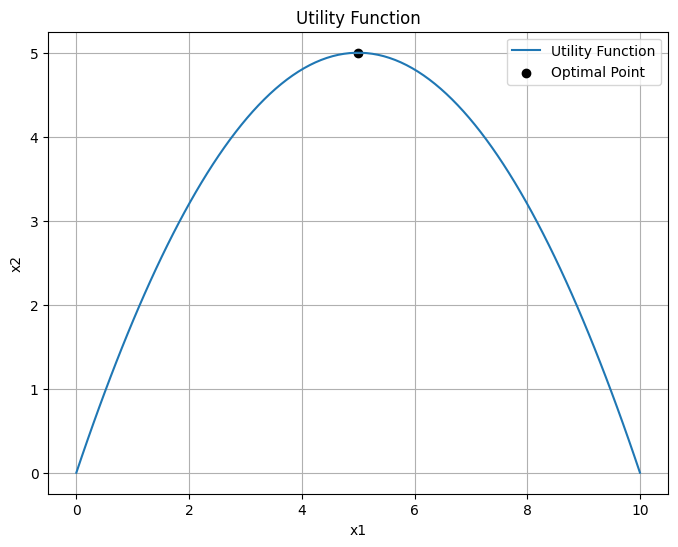

In [7]:

# Benchmark parameter values
alpha, gamma = 0.5, -1
p1, p2 = 1, 1
I = 10
# Utility function
def utility(x1, x2):
    return 1/(alpha * x1 ** gamma + (1 - alpha) * x2 ** gamma)
# Budget constraint
def budget_constraint(x1):
    return (I - p1 * x1) / p2
# Define the utility function after substituting the budget constraint
def utility_with_budget(x1):
    x2 = budget_constraint(x1)
    return utility(x1, x2)
def mygolden(f, a, b, maxit = 1000, tol = 1/10000):
    #Define the ratios
    alpha1 = (3 - np.sqrt(5)) / 2
    alpha2 = (np.sqrt(5) - 1) / 2
    #Prevent mistakes in the initial set
    if a > b:
        a, b = b, a
    #Compute the first two interior points        
    x1 = a + alpha1 * (b - a)
    x2 = a + alpha2 * (b - a)
    #Compute the associated values of f(.)
    f1, f2 = f(x1), f(x2)
    #Initialize the update factor (in the first iteration it is different)
    d = (alpha1 * alpha2)*(b - a)
    #Iterate until convergence
    while d > tol:
        #Compute the update factor
        d = d * alpha2 # alpha2 is the golden ratio
        #Generate a new interior point
        if f2 < f1: # x2 is new upper bound
            x2, x1 = x1, x1 - d
            f2, f1 = f1, f(x1)
        else:  # x1 is new lower bound
            x1, x2 = x2, x2 + d
            f1, f2 = f2, f(x2)            
    if f1>f2:
        x = x2
    else:
        x = x1      
    return x    
# Set the range for x1
a, b = .1, 10
# Use mygolden function to maximize utility
maximized_x1 = mygolden(utility_with_budget, a, b)
# Calculate corresponding x2 using the budget constraint
maximized_x2 = (I - p1 * maximized_x1) / p2
U = 1/(alpha * maximized_x1 ** gamma + (1 - alpha) * maximized_x2 ** gamma)
# Print the optimal values
print("Optimal x1:", maximized_x1)
print("Optimal x2:", maximized_x2)
print("Maximum utility:", U)
# Plot the utility function 
x1_values = np.linspace(0, b, 100)
x2_values = budget_constraint(x1_values)
# Calculate utility values for a range of x1 values
utility_values = utility_with_budget(x1_values)
# Plot the utility function
plt.figure(figsize=(8, 6))
plt.plot(x1_values, utility_values, label='Utility Function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Utility Function')
# Mark the optimal point
plt.scatter(maximized_x1, utility(maximized_x1, maximized_x2), color='black', label='Optimal Point')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Define utility function
def utility(x1, x2, alpha, gamma):
    return (alpha * x1 ** gamma + (1 - alpha) * x2 ** gamma) ** (1 / gamma)
# Define budget constraint function
def budget_constraint(x1, p1, p2, I):
    return (I - p1 * x1) / p2
# Define function to find optimal values
def find_optimal_values(alpha, gamma, p1, p2, I, a=0.1, b=8):
    # Define utility function after substituting the budget constraint
    def utility_with_budget(x1):
        x2 = budget_constraint(x1, p1, p2, I)
        return utility(x1, x2, alpha, gamma)
    # Use golden section search to maximize utility
    maximized_x1 = mygolden(utility_with_budget, a, b)
    maximized_x2 = budget_constraint(maximized_x1, p1, p2, I)
    return maximized_x1, maximized_x2, utility(maximized_x1, maximized_x2, alpha, gamma)
# Initialize data
data = {
    'Alpha': [0.5, 0.25, 0.5],
    'Gamma': [-5, -1, -1],
    'p1': [1, 1, 1],
    'p2': [1, 1, 2],
    'I': [10, 10, 20],
    'Optimal x1': [],
    'Optimal x2': [],
    'Maximum utility': []
}
# Populate data with optimal values
for i in range(len(data['Alpha'])):
    alpha = data['Alpha'][i]
    gamma = data['Gamma'][i]
    p1 = data['p1'][i]
    p2 = data['p2'][i]
    I = data['I'][i]
    x1, x2, utility_value = find_optimal_values(alpha, gamma, p1, p2, I)
    data['Optimal x1'].append(x1)
    data['Optimal x2'].append(x2)
    data['Maximum utility'].append(utility_value)
# Create DataFrame
df = pd.DataFrame(data)
# Print the DataFrame
print(df)

   Alpha  Gamma  p1  p2   I  Optimal x1  Optimal x2  Maximum utility
0   0.50     -5   1   1  10    5.000043    4.999957         5.000000
1   0.25     -1   1   1  10    3.660146    6.339854         5.358984
2   0.50     -1   1   2  20    7.999801    6.000100         6.857135


Optimal values of x1, x2, x3: [1.65429295 1.19080985 0.77974614]
Maximum utility: 1.215907630712919


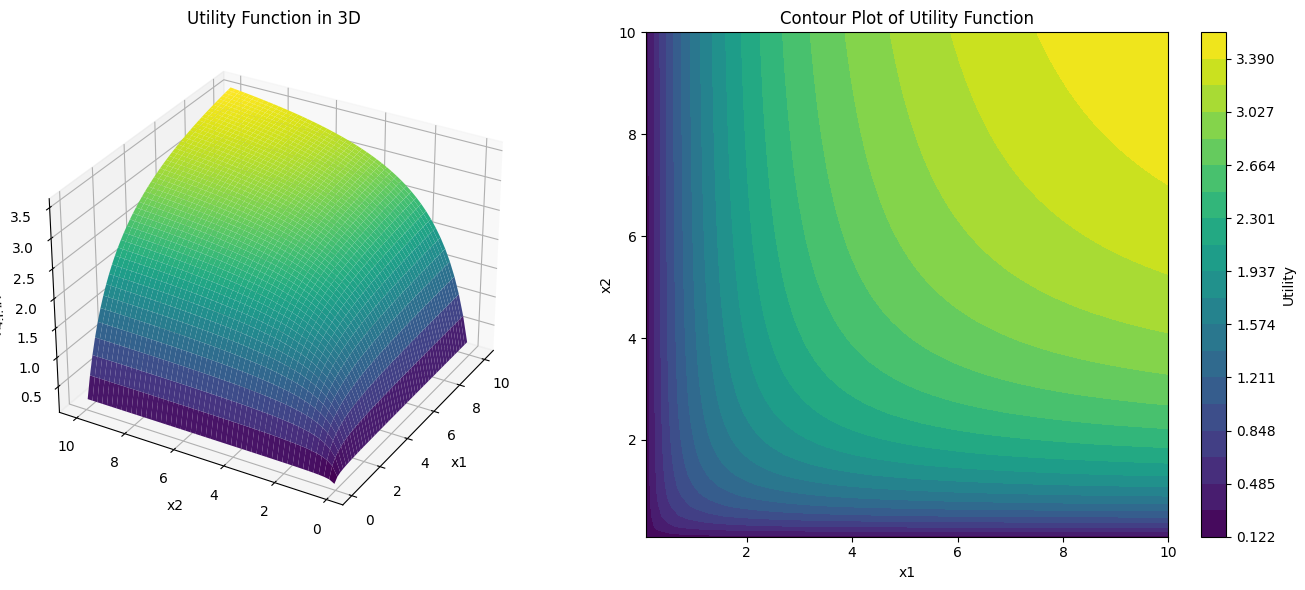

In [19]:
# Define utility function
def utility(x, alpha, beta, gamma):
    x1, x2, x3 = x
    return (alpha * x1 ** gamma + beta * x2 ** gamma + (1 - alpha - beta) * x3 ** gamma) ** (1 / gamma)
# Define budget constraint function
def budget_constraint(x, p1, p2, p3, I):
    return p1 * x[0] + p2 * x[1] + p3 * x[2] - I
# Define objective function
def objective(x, alpha, beta, gamma, p1, p2, p3, I):
    return -utility(x, alpha, beta, gamma)
# Benchmark parameter values
alpha = 0.45
beta = 0.35
gamma = -1
p1 = 2
p2 = 3
p3 = 4
I = 10
# Initial guess
x0 = np.array([1, 1, 1])
# Define constraints
constraints = ({'type': 'eq', 'fun': budget_constraint, 'args': (p1, p2, p3, I)})
# Perform optimization
result = minimize(objective, x0, args=(alpha, beta, gamma, p1, p2, p3, I), constraints=constraints)
# Extract optimal values
optimal_x = result.x
max_utility = -result.fun
# Print results
print("Optimal values of x1, x2, x3:", optimal_x)
print("Maximum utility:", max_utility)
# Generate data for plotting
x_range = np.linspace(0.1, 10, 50)
y_range = np.linspace(0.1, 10, 50)
X, Y = np.meshgrid(x_range, y_range)
Z = utility([X, Y, np.ones_like(X)], alpha, beta, gamma)
# Plotting
fig = plt.figure(figsize=(14, 6))
# 3D Surface Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Utility')
ax1.set_title('Utility Function in 3D')
ax1.view_init(30, 210)
# Contour Plot
ax2 = fig.add_subplot(1, 2, 2)
contour_levels = np.linspace(np.min(Z), np.max(Z), 20)
contour = ax2.contourf(X, Y, Z, levels=contour_levels, cmap='viridis')
plt.colorbar(contour, ax=ax2, label='Utility')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Contour Plot of Utility Function')
plt.tight_layout()
plt.show()